# try using LGB

In [1]:
# import required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgb
import os
from time import time

get_ipython().run_line_magic('matplotlib', 'inline')

/Users/teddyz/anaconda3/envs/rossmann/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## loading data

In [2]:
print(os.listdir("./input"))

['.DS_Store', 'rossmann-store-sales', '.ipynb_checkpoints']


In [3]:
# read data

train = pd.read_csv("./input/rossmann-store-sales/train.csv", parse_dates=[2], low_memory=False)
test = pd.read_csv("./input/rossmann-store-sales/test.csv", parse_dates=[3], low_memory=False)
store = pd.read_csv("./input/rossmann-store-sales/store.csv", low_memory=False)


> ## Data Cleaning

In [4]:
# the store should be open in the test,so we fillna with 1
test.Open.fillna(1, inplace=True)

In [5]:
display(train.isnull().sum(),test.isnull().sum(),store.isnull().sum())

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

Id               0
Store            0
DayOfWeek        0
Date             0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [6]:
train = pd.merge(train, store, on='Store')
test = pd.merge(test, store, on='Store')

In [7]:
# split the last 6 weeks data as hold-out set (idea from Gert https://www.kaggle.com/c/rossmann-store-sales/discussion/18024)
train = train.sort_values(['Date'],ascending = False)

x_hold = train[:6*7*1115]
x_train = train[6*7*1115:]

In [8]:
# only use data of Sales > 0 and Open is 1

# x_hold = x_hold[x_hold["Open"] != 0]
x_hold = x_hold[x_hold["Sales"] > 0]
# x_train = x_train[x_train["Open"] != 0]
x_train = x_train[x_train["Sales"] > 0]

In [9]:
# feature creation (code based on  https://www.kaggle.com/cast42/xgboost-in-python-with-rmspe-v2/code)

def covert_seq(seq):
    """add promo seq"""
    new_seq = list()
    j = 0
    last = None
    for i in seq:
        if last == 0 and i == 1:
            j = 0
        if i == 0:
            new_seq.append(10)
        elif i == 1:
            j += 1
            new_seq.append(j)
        else:
            raise
        last = i
    return new_seq  

def features_create(data:pd.DataFrame):    
    
    data = data.copy()
    
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    data['DayOfWeek'] = data.Date.dt.dayofweek
    data['WeekOfYear'] = data.Date.dt.weekofyear
    
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) +         (data.Month - data.CompetitionOpenSinceMonth)
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) +         (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['CompetitionOpen'] = data.CompetitionOpen.apply(lambda x: x if x > 0 else 0)        
    data['PromoOpen'] = data.PromoOpen.apply(lambda x: x if x > 0 else 0)
    data["CompetitionDistance_log1p"] = data["CompetitionDistance"].apply(np.log1p)
    
    # add promo seq
    data_promo = data.set_index(["Store", "Date"])["Promo"].copy()
    data_promo.sort_index(level=[0, 1], ascending=[True, True], inplace=True)
    data_promo = data_promo.to_frame()
    data_promo = data_promo.groupby(data_promo.index.get_level_values(0)).apply(lambda x: x.assign(Promo_seq=covert_seq(x["Promo"]))).reset_index()
    data = data.merge(data_promo.drop("Promo", 1), on=["Store", "Date"], how="left")
    
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['monthStr'] = data.Month.map(month2str)
    data.loc[data.PromoInterval.isnull(), 'PromoInterval'] = ''
    data['IsPromoMonth'] = 0
    for interval in data.PromoInterval.unique():
        if interval != '':
            for month in interval.split(','):
                data.loc[(data.monthStr == month) & (data.PromoInterval == interval), 'IsPromoMonth'] = 1
    return data

In [10]:
x_train = features_create(x_train)
x_hold = features_create(x_hold)
x_test = features_create(test)
print('Features creation finished')

Features creation finished


In [11]:
# drop the features of not help
drop_features = ['Date','Customers','Open','PromoInterval','monthStr', 'CompetitionDistance']
x_train.drop(drop_features, axis=1, inplace=True)
x_hold.drop(drop_features, axis=1, inplace =True)

test_drop_features = set(drop_features) & set(x_test) | set(["Id"]) 
x_test.drop(test_drop_features, 1, inplace=True)

In [12]:
y_train = np.log1p(x_train.Sales)
x_train = x_train.drop(['Sales'], axis=1)
y_hold = np.log1p(x_hold.Sales)
x_hold = x_hold.drop(['Sales'],axis=1 )

In [13]:
feature_set = x_train.columns.tolist()
categorical = ['Store','DayOfWeek','Promo','StateHoliday', 
               "SchoolHoliday", "StoreType", "Assortment", "Year", "Month", "Day", "WeekOfYear", "IsPromoMonth"]

In [14]:
assert all(x_test.columns == x_train.columns)
assert all(x_test.columns == x_hold.columns)

## modelling

In [15]:
# define rmspe for xgb(code from https://www.kaggle.com/cast42/xgboost-in-python-with-rmspe-v2/code)
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

def rmspe_lgb(yhat, dtrain):
    y = dtrain.get_label()
    return "rmspe", rmspe(y, yhat), False

In [16]:
## params

params = {
    'boosting_type': 'gbdt',
    'objective': 'mape',
    'max_depth': 15, 
    'num_leaves': 81,
    'learning_rate': 0.1,
    'verbose': 0,
    'num_thread': 8,
    "subsample": 0.9,
    "bagging_seed": 1307
}

num_boost_round = 6000
early_stopping_rounds = 200
verbose_eval = 100


In [17]:

dtrain = lgb.Dataset(x_train, y_train, feature_name=feature_set, categorical_feature=categorical)
dvalid = lgb.Dataset(x_hold, y_hold, feature_name=feature_set, categorical_feature=categorical)

# training model
print("Train a lgb model")
start = time()
evals_results = {}

lgbm = lgb.train(params, 
                 dtrain, 
                 valid_sets=[dtrain, dvalid], 
                 valid_names=['train','valid'], 
                 evals_result=evals_results, 
                 num_boost_round=num_boost_round,
                 early_stopping_rounds=early_stopping_rounds,
                 verbose_eval=verbose_eval, 
                 feval=rmspe_lgb)

end = time()
print('Training time is {:2f} s.'.format(end-start))

# save model
lgbm.save_model("0001.model")

# checking with hold-on dataset
print("validating")
x_hold.sort_index(inplace=True) 
y_hold.sort_index(inplace=True) 

yhat = lgbm.predict(x_hold, num_iteration=lgbm.best_iteration)
error = rmspe(y_hold, yhat)

print('RMSPE: {:.6f}'.format(error))

Train a lgb model
Training until validation scores don't improve for 200 rounds.
[100]	train's mape: 0.00901376	train's rmspe: 0.0139248	valid's mape: 0.0113884	valid's rmspe: 0.0154069
[200]	train's mape: 0.00798305	train's rmspe: 0.0123475	valid's mape: 0.0106033	valid's rmspe: 0.0142094
[300]	train's mape: 0.00762286	train's rmspe: 0.0119051	valid's mape: 0.010403	valid's rmspe: 0.0139111
[400]	train's mape: 0.0074757	train's rmspe: 0.0117539	valid's mape: 0.0103703	valid's rmspe: 0.0138641
[500]	train's mape: 0.00729445	train's rmspe: 0.0115544	valid's mape: 0.0103173	valid's rmspe: 0.0137926
[600]	train's mape: 0.00715016	train's rmspe: 0.0113967	valid's mape: 0.0102708	valid's rmspe: 0.0137213
[700]	train's mape: 0.00703991	train's rmspe: 0.0112715	valid's mape: 0.0102276	valid's rmspe: 0.0136386
[800]	train's mape: 0.00695836	train's rmspe: 0.0111758	valid's mape: 0.0102099	valid's rmspe: 0.0136049
[900]	train's mape: 0.00688453	train's rmspe: 0.0110972	valid's mape: 0.010188	va

/Users/teddyz/anaconda3/envs/rossmann/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/teddyz/anaconda3/envs/rossmann/lib/python3.7/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


In [18]:
# analysis by hold-out set
res = pd.DataFrame(data = y_hold)
res['Prediction'] = yhat
res = pd.merge(x_hold, res, left_index= True, right_index=True)
res['Prediction_True'] = res['Prediction'].apply(np.expm1)
res['Sales_True'] = res['Sales'].apply(np.expm1)
res['Ratio'] = res.Prediction / res.Sales
res['Ratio_True'] = res.Prediction.apply(np.expm1) / res.Sales.apply(np.expm1)
res['Error'] = abs(res.Ratio-1)
res['Weight'] = res.Sales / res.Prediction
res.head()

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,...,Promo_seq,IsPromoMonth,Sales,Prediction,Prediction_True,Sales_True,Ratio,Ratio_True,Error,Weight
0,1,4,1,0,1,3,1,9.0,2008.0,0,...,5,0,8.568646,8.526535,5045.925491,5263.0,0.995085,0.958755,0.004915,1.004939
1,747,4,1,0,1,3,3,8.0,2008.0,0,...,5,0,9.278840,9.206338,9959.060788,10708.0,0.992186,0.930058,0.007814,1.007875
2,772,4,1,0,1,4,3,NaN,NaN,0,...,5,0,8.561210,8.455963,4702.032658,5224.0,0.987706,0.900083,0.012294,1.012447
3,752,4,1,0,1,1,1,3.0,2013.0,1,...,5,0,8.957253,8.851405,6983.198351,7763.0,0.988183,0.899549,0.011817,1.011958
4,20,4,1,0,0,4,1,5.0,2009.0,1,...,5,1,9.168893,9.102049,8972.657454,9593.0,0.992710,0.935334,0.007290,1.007344


In [19]:
# whole correction

def correction(y_true, y_predict):
    W = [(0.990 + (i/1000)) for i in range(20)]
    score = []
    for w in W:
        error = rmspe(np.expm1(y_true), np.expm1(y_predict * w))
        score.append(error)
    score = pd.Series(score, index=W)
    best_weight = score[score == score.min()].index
    return best_weight

def correction_by_store(x_hold, x_test):
    store_no = x_hold["Store"].unique()
    
    weight_y_test = np.zeros(len(x_test))
    weight_y_hold = np.zeros(len(x_hold))

    store_weights = {}
    
    for no in store_no:
        df = x_hold[x_hold["Store"] == no]
        y_pred = df.Prediction
        y_true = df.Sales
        
        best_weight = correction(y_true, y_pred)
        store_weights[no] = best_weight
        
        weight_y_test[x_test.Store == no] = best_weight
        weight_y_hold[x_hold.Store == no] = best_weight

    return weight_y_hold, weight_y_test

In [20]:
w_hold, w_test = correction_by_store(res, x_test)

In [21]:
yhat_new = yhat * w_hold
error = rmspe(y_hold, yhat_new)
print('RMSPE for weight corretion {:6f}'.format(error))

RMSPE for weight corretion 0.012427


In [22]:
print("Make predictions on the test set")

test_probs = lgbm.predict(x_test)

# model1  kaggle private score
result = pd.DataFrame({"Id": test['Id'], 'Sales': np.expm1(test_probs)})
result.to_csv("Rossmann_submission_1.csv", index=False)

# model2 kaggle private score
result = pd.DataFrame({"Id": test['Id'], 'Sales': np.expm1(test_probs*0.995)})
result.to_csv("Rossmann_submission_2.csv", index=False)

# model3 kaggle private score 
result = pd.DataFrame({"Id": test['Id'], 'Sales': np.expm1(test_probs*w_test)})
result.to_csv("Rossmann_submission_3.csv", index=False)

Make predictions on the test set


<Figure size 720x432 with 0 Axes>

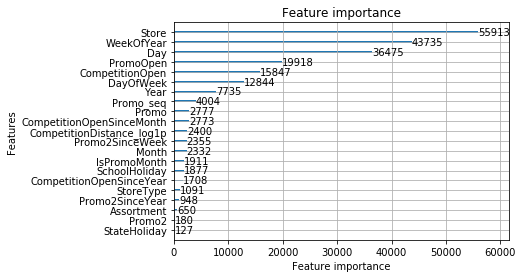

In [28]:
plt.figure(figsize=(10,6))
lgb.plot_importance(lgbm)
plt.savefig("importance.png")

In [24]:
# plot hold setb

In [25]:
res = res.sort_values(by=["Year", "Month", "Day"], ascending=[True, True, True])

Mean Ratio of predition and real sales data is 0.9879434363748263: store all
Mean Ratio of predition and real sales data is 1.0112616214253984: store 48
Mean Ratio of predition and real sales data is 0.8697412452825275: store 530
Mean Ratio of predition and real sales data is 1.005006129072619: store 78


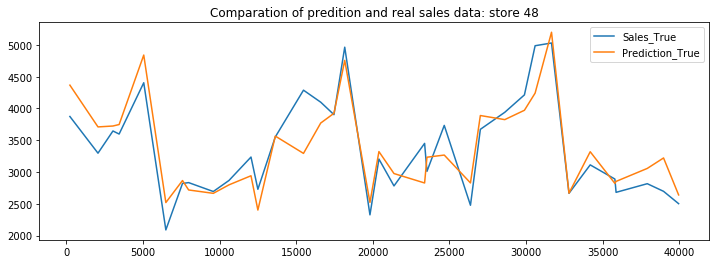

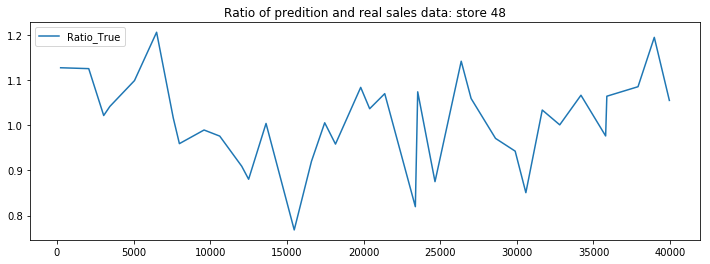

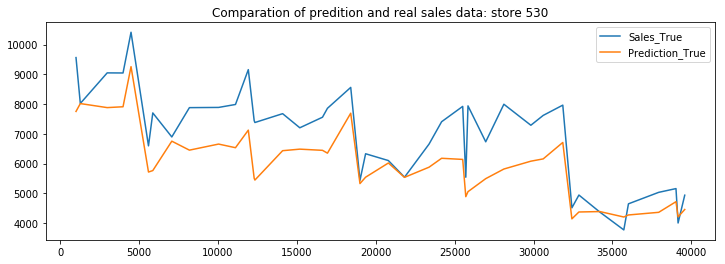

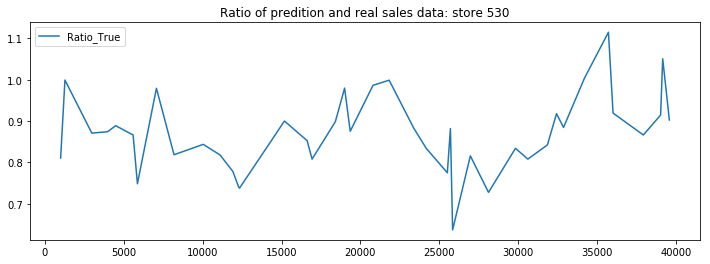

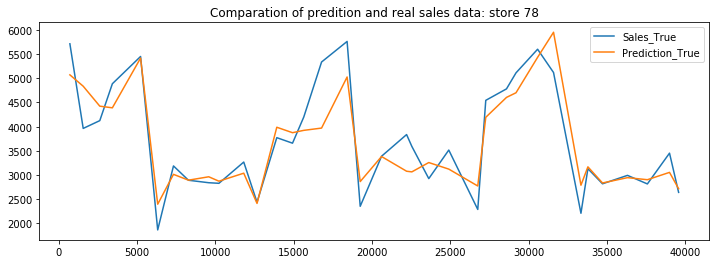

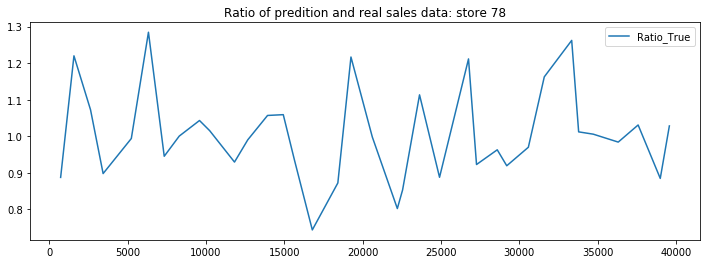

In [30]:
col_1 = ['Sales_True','Prediction_True']
col_2 = ['Ratio_True']

L = np.random.randint( low=1,high = 1115, size = 3 ) 
print('Mean Ratio of predition and real sales data is {}: store all'.format(res["Ratio_True"].mean()))
for i in L:
    
    s1 = pd.DataFrame(res[res['Store']==i],columns = col_1)
    s2 = pd.DataFrame(res[res['Store']==i],columns = col_2)
    s1.plot(title = 'Comparation of predition and real sales data: store {}'.format(i),figsize=(12,4))
    s2.plot(title = 'Ratio of predition and real sales data: store {}'.format(i),figsize=(12,4))
    print('Mean Ratio of predition and real sales data is {}: store {}'.format(s2["Ratio_True"].mean(),i))